In [1]:
%cd ..

/home/mounim/PHD-Projects/GES


In [2]:
#pip install matplotlib numpy pandas seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns
import random
import sys
from itertools import combinations
import scipy.cluster.hierarchy as shc
from Bio.pairwise2 import format_alignment
from src import dataset_simulator
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from Bio import pairwise2
from Bio import Align

In [3]:
## Binary tree
### N generations
version = "bimodal_dataset"
L = 100 # len of sequence
mutation_rate = 0.02
generations = 7 # N = g!
random_sequence = dataset_simulator.generate_random_seq(L) #sequence of lenght L
# make binary dataset 
simulated_dataset = dataset_simulator.make_binray_tree(random_sequence, generations = generations, mutation_rate = mutation_rate, mutation_types='S', distribution = 'bimodal')

dataset_simulator.dict_to_fasta(simulated_dataset , './data/'+version+'/' , filename = version)


# TEST DATA

Gen0:N0:  Gen5:N33
Gen1:N1:  Gen0:N0
Gen1:N2:  Gen0:N0
Gen2:N3:  Gen1:N1
Gen2:N5:  Gen3:N11
Gen2:N6:  Gen6:N114
Gen3:N7:  Gen0:N0
Gen3:N8:  Gen2:N3
Gen3:N9:  Gen2:N4
Gen3:N11:  Gen2:N5
Gen3:N12:  Gen5:N53
Gen3:N13:  Gen2:N6
Gen3:N14:  Gen5:N58
Gen4:N15:  Gen7:N189
Gen4:N16:  Gen3:N7
Gen4:N17:  Gen2:N3
Gen4:N18:  Gen2:N3
Gen4:N19:  Gen7:N164
Gen4:N20:  Gen5:N42
Gen4:N21:  Gen5:N44
Gen4:N22:  Gen6:N65
Gen4:N23:  Gen3:N11
Gen4:N25:  Gen3:N12
Gen4:N26:  Gen5:N53
Gen4:N28:  Gen3:N13
Gen4:N29:  Gen5:N58
Gen4:N30:  Gen5:N62
Gen5:N31:  Gen4:N15
Gen5:N32:  Gen7:N191
Gen5:N33:  Gen0:N0
Gen5:N35:  Gen4:N17
Gen5:N36:  Gen2:N3
Gen5:N37:  Gen4:N17
Gen5:N38:  Gen4:N18
Gen5:N39:  Gen7:N164
Gen5:N42:  Gen4:N20
Gen5:N43:  Gen4:N21
Gen5:N45:  Gen2:N4
Gen5:N46:  Gen6:N93
Gen5:N47:  Gen6:N95
Gen5:N48:  Gen4:N23
Gen5:N49:  Gen6:N100
Gen5:N52:  Gen4:N25
Gen5:N53:  Gen3:N12
Gen5:N54:  Gen4:N26
Gen5:N55:  Gen4:N27
Gen5:N56:  Gen7:N136
Gen5:N57:  Gen4:N28
Gen5:N59:  Gen4:N29
Gen5:N60:  Gen7:N235
Gen5:N61:  Gen7

/tmp/ipykernel_593122/1390965192.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1390965192.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1390965192.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1390965192.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1390965192.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

1.5000764525993886


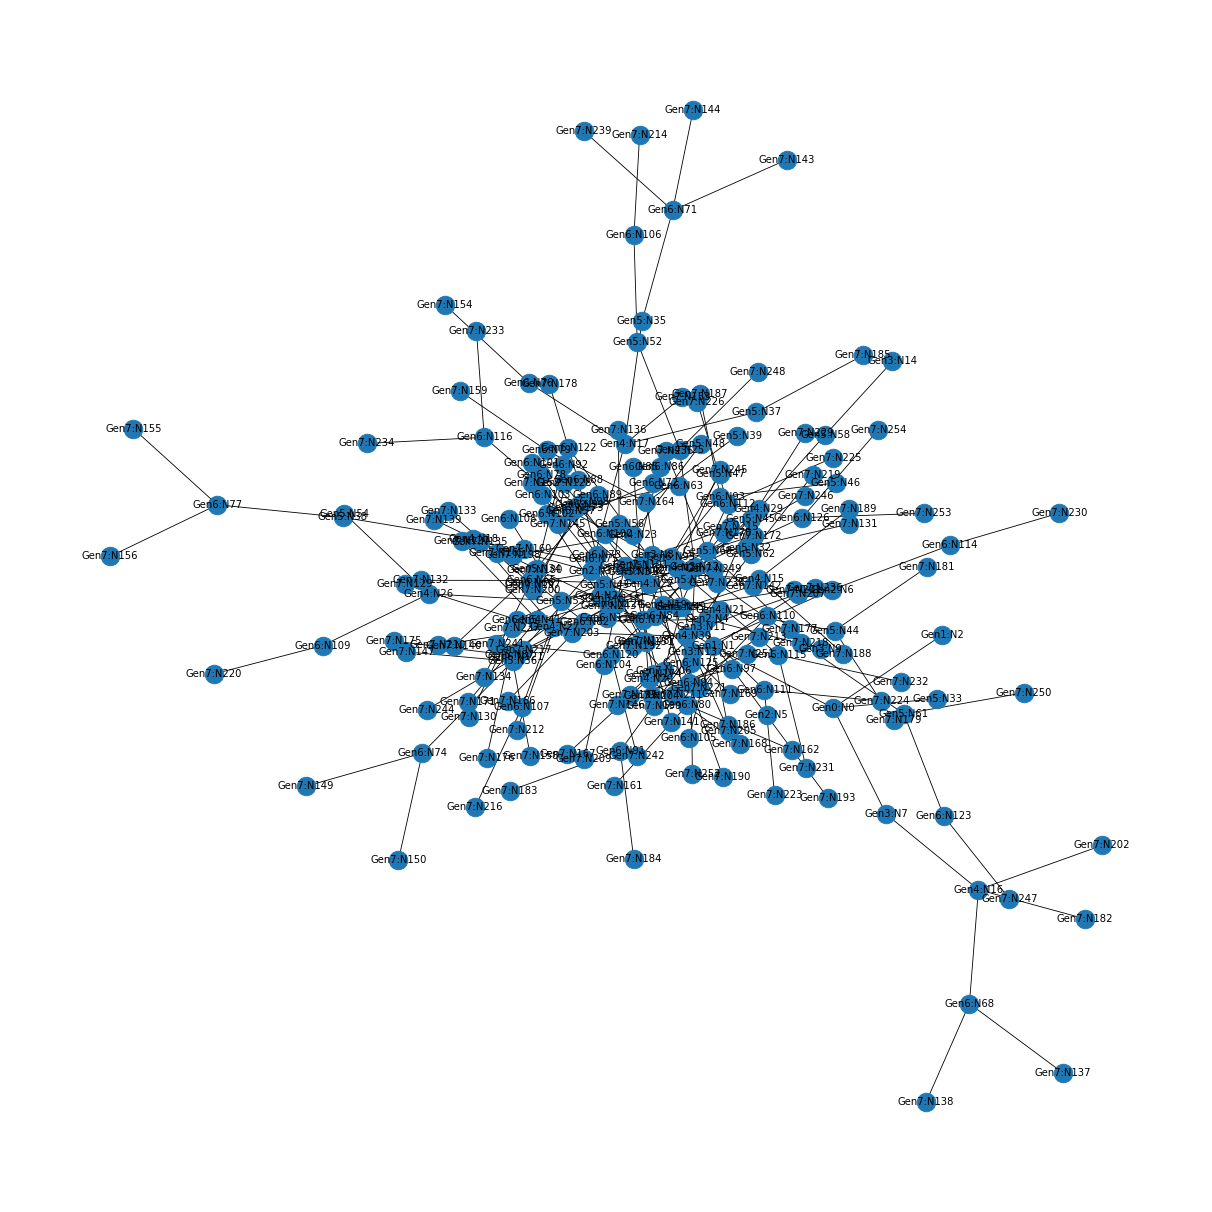

In [4]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
# simulated_dataset = predicted_dataset
 
# for end-node make childs


predicted_dataset = simulated_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())




(0.0, 100.0)

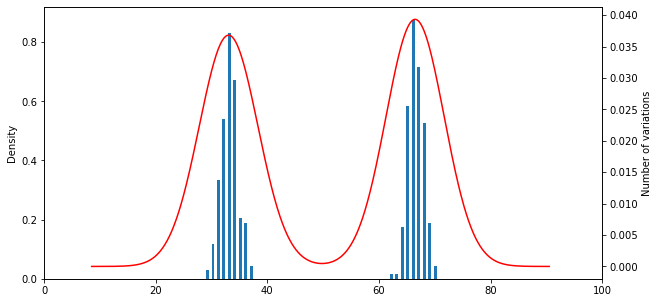

In [5]:
vars_test = vars_all

fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_test.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_test.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)


### NW Align

Gen0:N0:  ['Gen1:N1']
Gen1:N1:  ['Gen0:N0']
Gen1:N2:  ['Gen0:N0']
Gen2:N3:  ['Gen1:N1']
Gen2:N4:  []
Gen2:N5:  ['Gen3:N11']
Gen2:N6:  ['Gen1:N2']
Gen3:N7:  ['Gen0:N0']
Gen3:N8:  ['Gen2:N3']
Gen3:N9:  ['Gen2:N4']
Gen3:N10:  []
Gen3:N11:  ['Gen2:N5']
Gen3:N12:  ['Gen2:N5']
Gen3:N13:  ['Gen2:N6']
Gen3:N14:  ['Gen2:N6']
Gen4:N15:  ['Gen3:N7']
Gen4:N16:  ['Gen3:N7']
Gen4:N17:  ['Gen2:N3']
Gen4:N18:  ['Gen2:N3']
Gen4:N19:  ['Gen3:N9']
Gen4:N20:  ['Gen2:N6']
Gen4:N21:  ['Gen2:N4']
Gen4:N22:  ['Gen2:N4']
Gen4:N23:  ['Gen3:N11']
Gen4:N24:  ['Gen3:N11']
Gen4:N25:  ['Gen3:N12']
Gen4:N26:  ['Gen3:N12']
Gen4:N27:  ['Gen2:N6']
Gen4:N28:  ['Gen3:N13']
Gen4:N29:  ['Gen3:N14']
Gen4:N30:  ['Gen3:N12']


/tmp/ipykernel_593122/1577463388.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1577463388.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1577463388.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1577463388.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1577463388.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

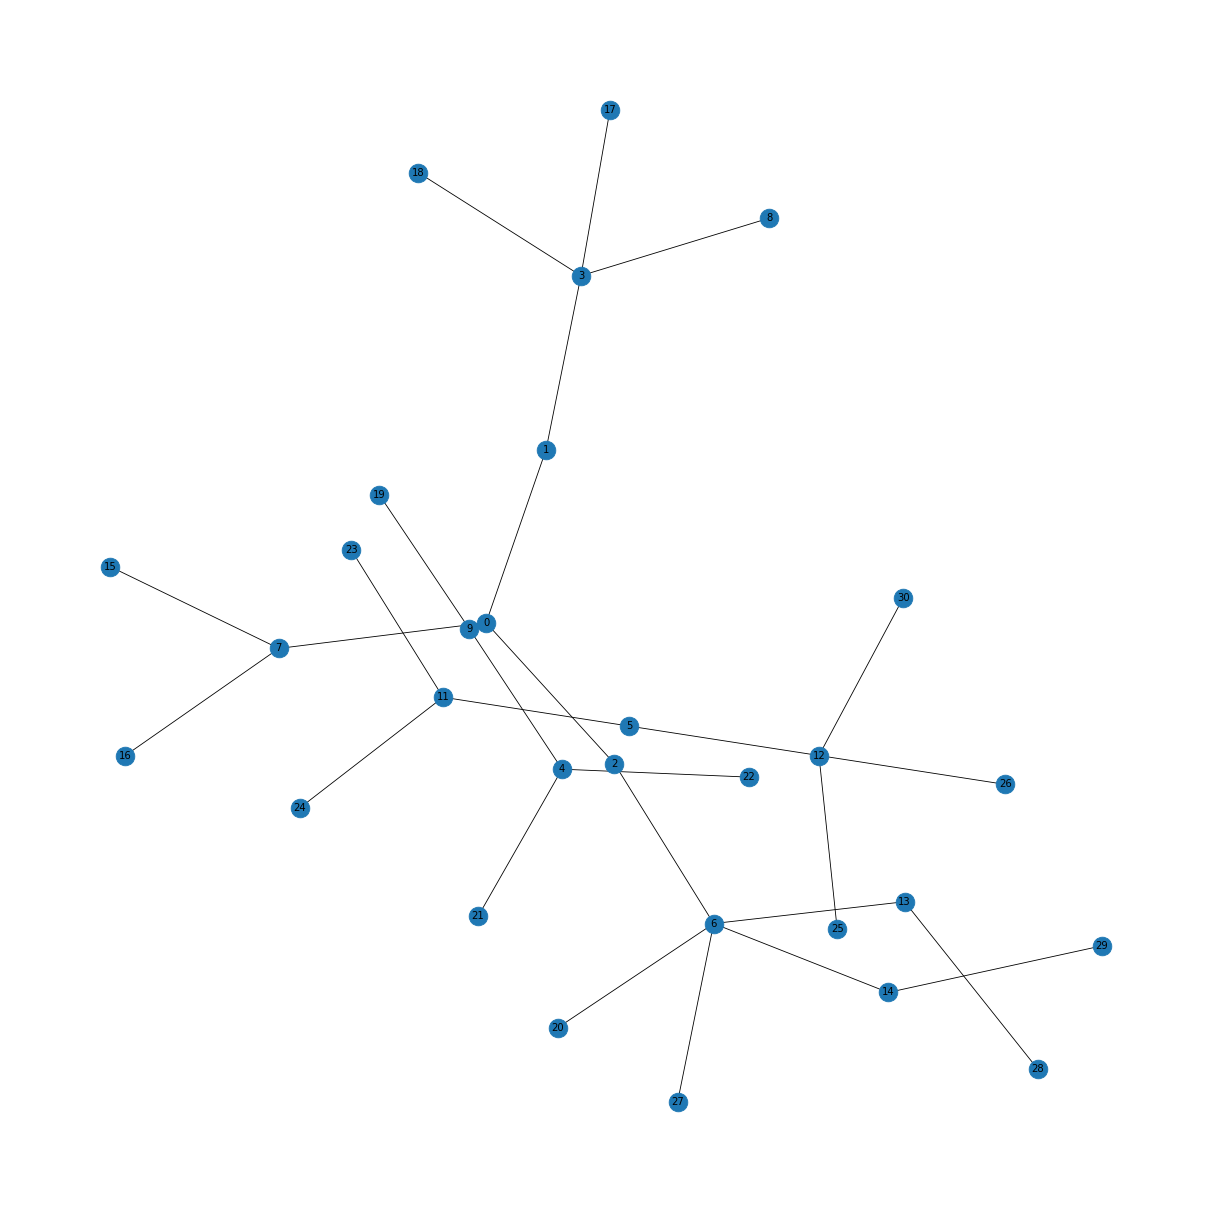

In [6]:

original_dataset = simulated_dataset
train_dataset = {}
test_dataset = {}
N_gen = 5
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G < N_gen:
        train_dataset[id] = simulated_dataset[id]
    else:
        test_dataset[id] = simulated_dataset[id]


# 1. pairwise align
path = './data/tmp/'

simulated_dataset = train_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])




names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])


import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        print(i + ": ", list(Y.columns))
        for c in list(Y.columns):
            edges.append([i, c])


Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id).split('N')[1]
    i+=1
id_map
edgelist = Edges.replace({0 : id_map, 1 : id_map} )
edgelist.columns = ['source','target']



fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


from sklearn import linear_model

# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()


vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')



mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

vars = vars_all
vars_G1 = vars_all


(0.0, 100.0)

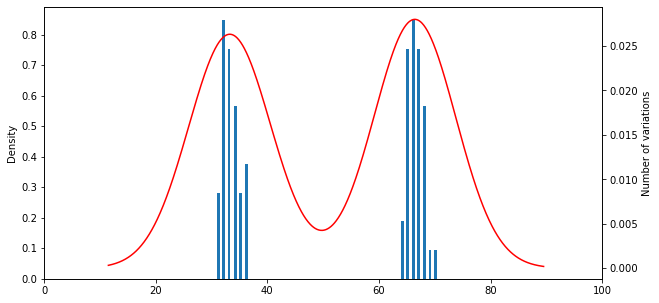

In [7]:

vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)


In [8]:
from Bio import pairwise2
from Bio import Align
import scipy
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

mut_rate = pd.concat( [mut_rate ,  pd.DataFrame({'x' : [0] , 'y' : [0]})] )

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
r = mut_rate_all.x  / mut_rate_all.y
N = round( r.mean() ) # N = number of mut per generation

new_dataset = {}
# define childs
# select seq from last generation to mutate
last_gen = 4
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G >= last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

Var = vars_all
di = dict({'A':0,'C':1,'G':2,'T':3, '-':4})
Var.ref = Var['ref'].map(di)
Var.tar = Var['tar'].map(di)
Var.pos = Var['pos']
X = Var[['ref','pos']]
y = Var[['tar']]


randomforest = RandomForestClassifier()
randomforest.fit(X, y)



def reverse_map(lst):
    new_list = []
    while len(lst):
        e = lst.pop()
        e = str(e).replace('0','A').replace('1','C').replace('2','G').replace('3','T')
        new_list.append(e)
    return new_list

mu, std = scipy.stats.norm.fit(np.array(vars_all['pos'], dtype=int) )

/tmp/ipykernel_593122/64793630.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomforest.fit(X, y)


# Precit G +1

Gen4:N15
Gen4:N16
Gen4:N17
Gen4:N18
Gen4:N19
Gen4:N20
Gen4:N21
Gen4:N22
Gen4:N23
Gen4:N24
Gen4:N25
Gen4:N26
Gen4:N27
Gen4:N28
Gen4:N29
Gen4:N30
Gen0:N0:  Gen1:N1
Gen1:N1:  Gen0:N0
Gen1:N2:  Gen0:N0
Gen2:N3:  Gen1:N1
Gen2:N5:  Gen3:N11
Gen2:N6:  Gen1:N2
Gen3:N7:  Gen0:N0
Gen3:N8:  Gen2:N3
Gen3:N9:  Gen2:N4
Gen3:N11:  Gen2:N5
Gen3:N12:  Gen2:N5
Gen3:N13:  Gen2:N6
Gen3:N14:  Gen2:N6
Gen4:N15:  Gen5:N2
Gen4:N16:  Gen3:N7
Gen4:N17:  Gen2:N3
Gen4:N18:  Gen5:N7
Gen4:N19:  Gen3:N9
Gen4:N20:  Gen5:N12
Gen4:N21:  Gen2:N4
Gen4:N22:  Gen2:N4
Gen4:N23:  Gen3:N11
Gen4:N24:  Gen5:N19
Gen4:N25:  Gen5:N22
Gen4:N26:  Gen3:N12
Gen4:N27:  Gen2:N6
Gen4:N28:  Gen3:N13
Gen4:N29:  Gen3:N14
Gen4:N30:  Gen3:N12
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N1:  Gen4:N15
Gen5:N2:  Gen4:N15
Gen5:N2:  Gen4:N15
Gen5:N2:  Gen4:N15
Gen5:N2:  Gen4:N15
Gen5:N2:  Gen4:N15
G

/tmp/ipykernel_593122/1808333702.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1808333702.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1808333702.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1808333702.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_593122/1808333702.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

1.7817460317460316


(0.0, 100.0)

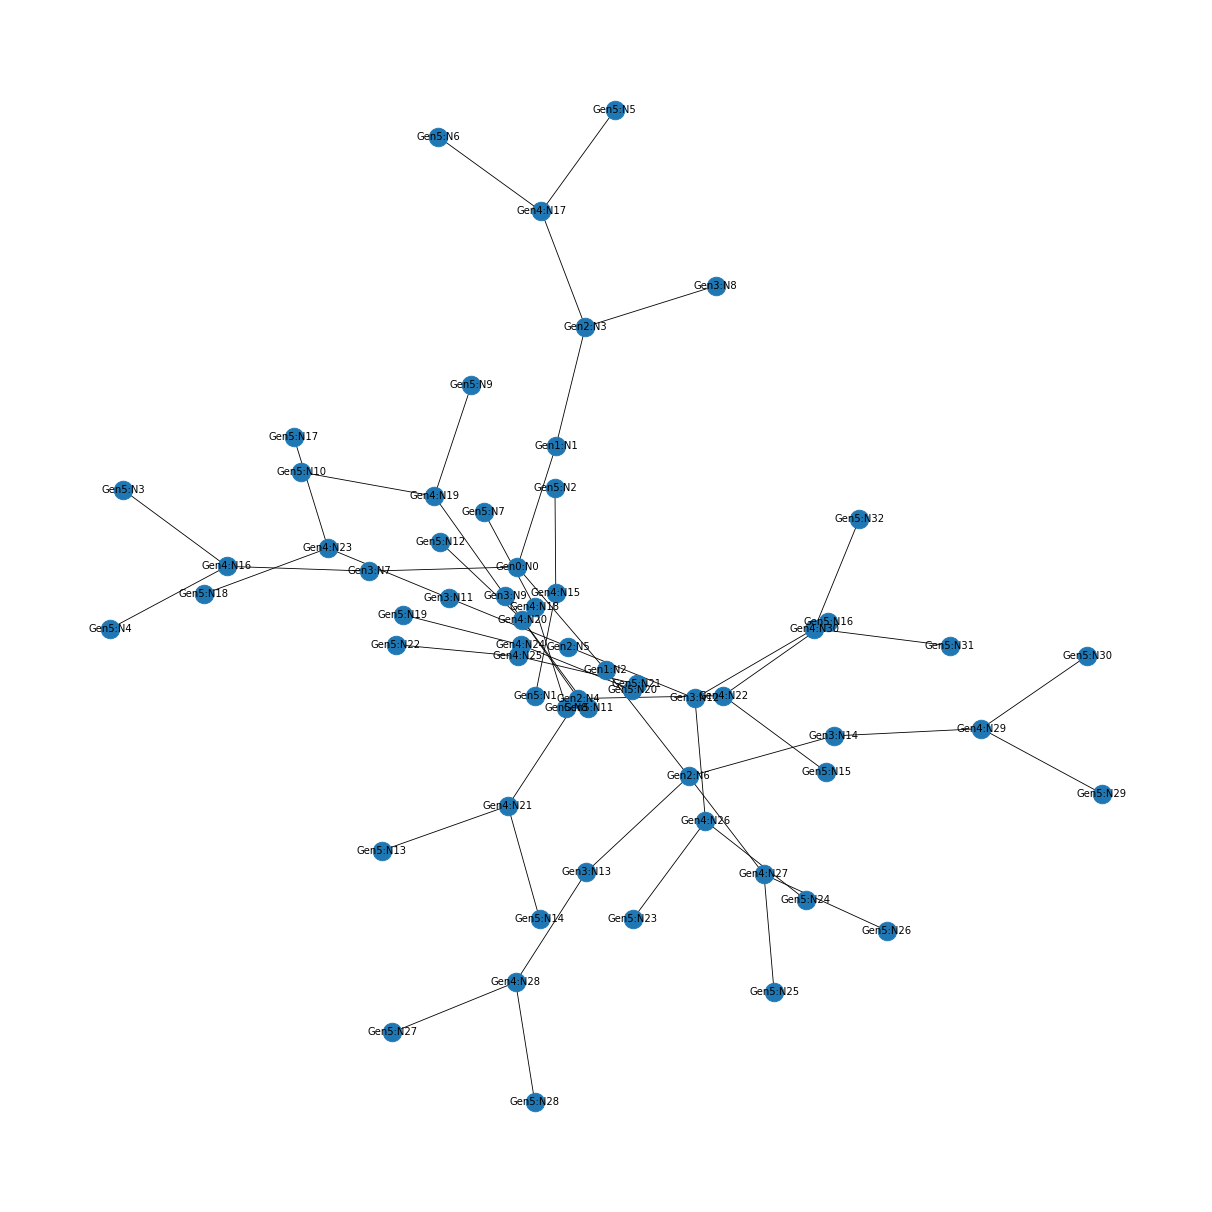

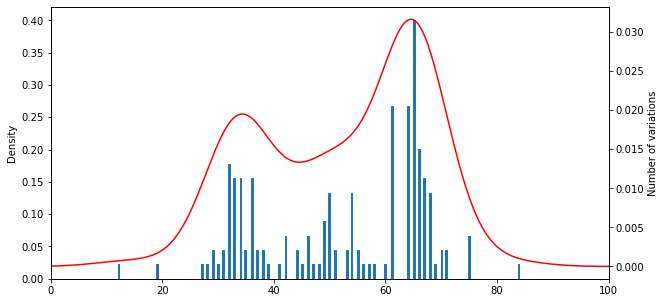

In [9]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
# simulated_dataset = predicted_dataset
simulated_dataset = train_dataset

last_gen = 4
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r']get_truncated_normal = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())

vars_G2 = vars_all

vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)



# G +2

In [10]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
simulated_dataset = predicted_dataset

last_gen = 5
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())


vars_G3 = vars_all

vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)

Gen5:N1


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# GEN ++3

In [ ]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
simulated_dataset = predicted_dataset

last_gen = 6
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())


vars_G4 = vars_all

vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)

# G +3

In [ ]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
simulated_dataset = predicted_dataset

last_gen = 7
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())


vars_G5 = vars_all



vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)

# G +4

In [ ]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
simulated_dataset = predicted_dataset

last_gen = 8
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())



vars_all
vars_G6 = vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)

# G +5

In [ ]:
new_dataset = {}
# define childs
# select seq from last generation to mutate
simulated_dataset = predicted_dataset

last_gen = 9
last_gen_dataset = {}
for id in simulated_dataset:
    G = int(id.split(':')[0].replace('Gen',''))
    if G == last_gen:
        last_gen_dataset[id] = simulated_dataset[id]

# for end-node make childs
c = 0

G = last_gen
parents = last_gen_dataset
G += 1
for id in last_gen_dataset:
    print(id)
    seq = parents[id] 
    #right 
    c+=1
    N = round( r.mean() ) # N = number of mut per generation
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq
    #left 
    seq = parents[id] 
    c+=1
    pos = get_truncated_normal(mu, std, low=1, upp=L).rvs(N)
    refs = []
    for p in pos :
        refs.append(seq[int(p)])
    X_test = pd.DataFrame( { 'ref' : refs, 'pos' : pos } )
    X_test['ref'] = X_test['ref'].map(di)
    y_pred = randomforest.predict(X_test)
    y_Pred = reverse_map(list(y_pred))
    for i in range(len(pos)):
        p = int(pos[i])
        seq = seq[:p] + y_Pred[i] + seq[p+1:] # insert new mutated base in sequence
    new_dataset['Gen'+str(G)+":N"+str(c)]=seq

predicted_dataset = train_dataset | new_dataset

# 1. pairwise align
path = './data/tmp/'

simulated_dataset = predicted_dataset
ids = list(simulated_dataset)
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

names = set( score_matrix.index )

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])

import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 2
for i in X.index:
    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        targets = list(Y.columns)
        for c in targets:
            if c != i:
               print(i + ": ", c)
               edges.append([i, c])

Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id)
    i+=1
id_map
edgelist = Edges
edgelist.columns = ['source','target']

fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)


meta = []
for id in names:
    N = str(id).split('N')[1]
    ID = id
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([ Gen, ID, seq])
meta = pd.DataFrame(meta, columns=['Gen','id', 'seq'])

meta
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()
conneted_sequences



vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+version+'/vars'+'.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+version+'/mut_rate.csv')
from sklearn import linear_model

mut_rate_all = mut_rate

mut_rate_all = mut_rate_all[mut_rate_all.x > 0]
mut_rate_all = mut_rate_all[mut_rate_all.y > 0]
mut_rate_all['r'] = mut_rate_all.x  / mut_rate_all.y

print(mut_rate_all['r'].mean())

vars_G7 = vars_all


vars_all
fig, ax = plt.subplots(figsize = (10,5))
# plt.style.use("ggplot")
# vars.pos.plot.hist(bins=100, linewidth=1, ax = ax, density = True, normed=True)
vars_all.pos.plot(kind ='hist', bins=250, width=0.5, ax = ax, density = True)
vars_all.pos.plot.kde(c = 'r', ax = ax, secondary_y=True)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)


In [ ]:

vars_G2 
vars_G3
vars_all

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize = (10,5))

vars_G1.pos.plot.kde(c = 'b', ax = ax)
# vars_test.pos.plot.kde(c = 'y', ax = ax)
vars_G5.pos.plot.kde(c = 'r', ax = ax)
vars_test.pos.plot.kde(c = 'y', ax = ax)

# vars_G7.pos.plot.kde(c = 'r', ax = ax)
# ax.legend(labels=['New genetic variations'], frameon=False)
plt.xlabel("Position in the sequence")
plt.ylabel("Number of variations")
ax.set_xlim(0,100)

In [ ]:
vars_test